In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

In [2]:
df = pd.read_csv('transactions-2023-01-11.csv')

In [3]:
def drop_excess_columns(data):
    # Drop high cardinality columns
    data = data.drop(columns=["Transaction Number", "Property ID", "Transaction Size (sq.m)", "Parking", "Project"])
    # Drop low-cardinality columns
    data = data.drop(columns=["Registration type", "Is Free Hold?", "Master Project"])
    # Drop leaky columns
    data = data.drop(columns=["Transaction sub type", "Property Type", "Room(s)", "No. of Buyer", "No. of Seller"])
    return data


In [4]:
df = drop_excess_columns(df)

In [5]:
def get_oil_price():
    # data from https://tradingeconomics.com/commodity/crude-oil
    r = requests.get('https://markets.tradingeconomics.com/chart?s=cl1:com&interval=1d&span=5y&securify=new&url=/commodity/crude-oil&AUTH=Q8lxP7S8XEYlloC%2FSMr0eTGbD53NoztMkkM1MDEJCyQhuim5sw4GTlleWJqfGRet&ohlc=0')
    
    oil_data = pd.DataFrame(r.json()['series'][0]['data']).rename(columns={"y": "Oil Price"})
    oil_data = oil_data[(oil_data['date'] > '2021-03-01') & (oil_data['date'] < '2022-02-04')]

    return oil_data[['date', 'Oil Price']]
    

In [6]:
oil_data = get_oil_price()
oil_data

,date,Oil Price
864,2021-03-01T00:00:00,60.64
865,2021-03-02T00:00:00,59.75
866,2021-03-03T00:00:00,61.28
867,2021-03-04T00:00:00,63.83
868,2021-03-05T00:00:00,66.09
...,...,...
1100,2022-01-28T00:00:00,85.43
1101,2022-01-31T00:00:00,86.49
1102,2022-02-01T00:00:00,86.46
1103,2022-02-02T00:00:00,86.69


In [7]:
def drop_period_after_war(data):
    war_date = '2022-02-24'
    return data[data['Transaction Date'] < war_date]

In [8]:
df = drop_period_after_war(df)

In [9]:
def merge_oil_to_data(data, oil):
    data['date_without_time'] = pd.to_datetime(data['Transaction Date']).dt.strftime('%Y-%m-%d')
    oil['date_without_time'] = pd.to_datetime(oil['date']).dt.strftime('%Y-%m-%d')
    data = data.merge(oil, left_on='date_without_time', right_on='date_without_time')
    return data

In [10]:
df = merge_oil_to_data(df, oil_data)

In [11]:
df

,Transaction Date,Transaction Type,Usage,Area,Property Sub Type,Amount,Property Size (sq.m),Nearest Metro,Nearest Mall,Nearest Landmark,date_without_time,date,Oil Price
0,2021-03-02 13:53:10,Mortgage,Residential,AL BARARI,Flat,1435909.09,138.93,NaN,NaN,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75
1,2021-03-02 13:53:10,Mortgage,Residential,AL BARARI,Flat,1435909.09,87.26,NaN,NaN,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75
2,2021-03-02 13:53:10,Mortgage,Residential,AL BARARI,Flat,1435909.09,76.13,NaN,NaN,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75
3,2021-03-02 13:53:10,Mortgage,Residential,AL BARARI,Flat,1435909.09,130.05,NaN,NaN,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75
4,2021-03-02 13:53:10,Mortgage,Residential,AL BARARI,Flat,1435909.09,52.15,NaN,NaN,IMG World Adventures,2021-03-02,2021-03-02T00:00:00,59.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69700,2021-07-23 03:41:08,Mortgage,Residential,JUMEIRAH VILLAGE CIRCLE,Flat,888655.00,106.55,Dubai Internet City,Mall of the Emirates,Sports City Swimming Academy,2021-07-23,2021-07-23T00:00:00,72.07
69701,2021-07-30 01:08:56,Mortgage,Residential,ARABIAN RANCHES II,Residential,3283133.00,836.75,NaN,NaN,Motor City,2021-07-30,2021-07-30T00:00:00,73.95
69702,2021-07-30 01:42:39,Mortgage,Residential,Nad Al Shiba Third,NaN,2270000.00,468.74,Creek Metro Station,City Centre Mirdif,NaN,2021-07-30,2021-07-30T00:00:00,73.95
69703,2021-07-30 01:44:58,Mortgage,Residential,Nad Al Shiba Third,NaN,2155300.00,469.30,Creek Metro Station,City Centre Mirdif,NaN,2021-07-30,2021-07-30T00:00:00,73.95


In [12]:
def clean_outliers_in_data(data):
    quantiles = data.quantile(0.98)
    data = data[(data['Amount'] < quantiles['Amount']) & (data['Property Size (sq.m)'] < quantiles['Property Size (sq.m)'])]
    data = data[data['Property Sub Type'].isin(["Commercial", "Flat", "Hotel Apartment", "Hotel Rooms",  "Office", "Residential", "Residential / Attached Villas","Residential Flats", "Stacked Townhouses", "Villa"])]
    data = data.dropna()
    return data

In [13]:
cleaned_df = clean_outliers_in_data(df)

/var/folders/41/gxq0b1712fbb5k5ndrr4d4cw0000gn/T/ipykernel_1557/708482841.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantiles = data.quantile(0.98)


In [14]:
from pandas.plotting import scatter_matrix

def plot_matrix(data):
    scatter_matrix(data[['Amount', 'Property Size (sq.m)']], figsize=(12, 8))
    return data['Property Size (sq.m)'].describe()

count    43595.000000
mean       179.171362
std        220.355850
min          7.300000
25%         69.380000
50%        107.490000
75%        180.000000
max       1732.500000
Name: Property Size (sq.m), dtype: float64

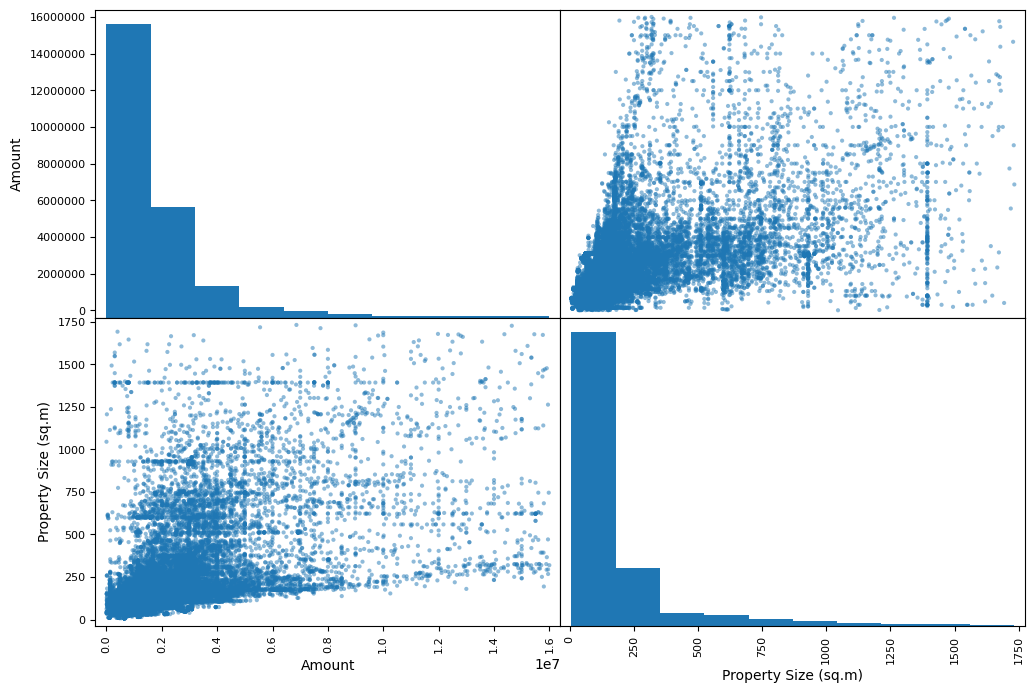

In [15]:
plot_matrix(cleaned_df)

In [16]:
def preparing_data_before_training(data, drop, renameColumns):
    data = data.drop(drop, axis=1)
    data = data.rename(columns=renameColumns)
    return data

In [17]:
prepared_data = preparing_data_before_training(
    cleaned_df, 
    ['date_without_time', 'Transaction Date', 'date'],
    {
        'Property Size (sq.m)': 'Property_Size',
        'Property Sub Type': 'Property_Sub_Type',
        'Nearest Metro': 'Nearest_Metro',
        'Nearest Mall': 'Nearest_Mall',
        'Nearest Landmark': 'Nearest_Landmark',
        'Oil Price': 'Oil_Price',
        'Transaction Type': 'Transaction_Type',
    }
)

In [18]:
import statsmodels.formula.api as smf

sm_data = sm.add_constant(prepared_data)
model = smf.ols(formula='Amount ~ C(Transaction_Type) + C(Usage) + C(Area) + C(Property_Sub_Type) + Property_Size + C(Nearest_Metro) + C(Nearest_Mall) + C(Nearest_Landmark) + Oil_Price', data=sm_data)
results = model.fit()

eval_env: 1


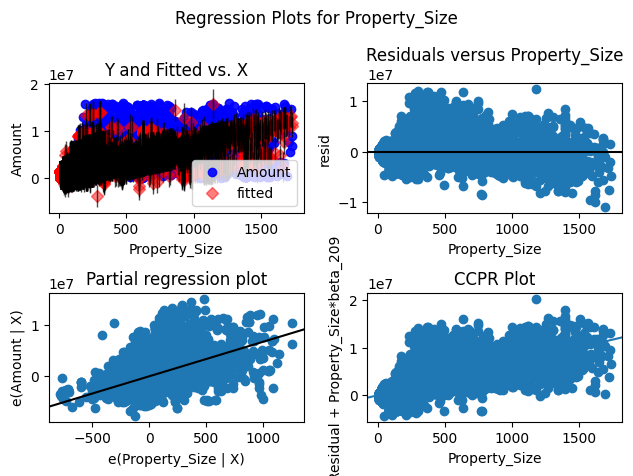

In [19]:
fig = sm.graphics.plot_regress_exog(results, "Property_Size")
fig.tight_layout(pad=1.0)